In [1]:
from math import log, exp
import itertools
import math
import random
import scipy

class GSOM_Node:
    R = random.Random()
    
    def __init__(self, dim, x, y):
        # Crie um vetor de peso da dimensão fornecida:
        # Inicialize o vetor de peso com valores aleatórios entre 0 e 1.
        self.weights=scipy.array([self.R.random() for _ in range(dim)])

        self.error = 0.0

        self.it = 0
        self.last_it = 0

        self.data = None
        self.last_changed = 0

        self.right = None
        self.left  = None
        self.up    = None
        self.down  = None

        self.x, self.y = x, y


    def adjust_weights(self, target, learn_rate):
        """ Adjust the weights of this node. """
        for w in range(0, len(target)):
            self.weights[w] += learn_rate * (target[w] - self.weights[w])


    def is_boundary(self):
        """ Check if this node is at the boundary of the map. """
        if not self.right: return True
        if not self.left:  return True
        if not self.up:    return True
        if not self.down:  return True
        return False



In [2]:
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import iris 
iris = datasets.load_iris()
dataset = iris
spread_factor = 1.5
# Atribuir os dados
data = []
for fn in dataset:
    t = dataset
    arr = scipy.array(t.data)
    data.append([fn,arr])

# Determine a dimensão dos dados.
dim = len(data[0][1])

# Calcule o limite de crescimento:
_GT = -dim * math.log(spread_factor, 2)

# Crie os 4 nós iniciais.
nodes = []
n00 = GSOM_Node(dim, 10, 10)
n01 = GSOM_Node(dim, 10, 11)
n10 = GSOM_Node(dim, 11, 10)
n11 = GSOM_Node(dim, 11, 11)
nodes.extend([n00,n01,n10,n11])

# Criar topologia inicial
n00.right = n10
n00.up    = n01
n01.right = n11
n01.down  = n00
n10.up    = n11
n10.left  = n00
n11.left  = n01
n11.down  = n10

# Definir propriedades
it = 0       
max_it = len(data)
num_it = 100     
init_lr = 0.5   
alpha = 0.2
output = file = open("gsom.csv","w")

print(len(n00.weights))

150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  del sys.path[0]


In [3]:
def _distance(v1, v2):
    dist = 0.0
    #print(v1)
    #print(v2)
    for v, w in zip(v1, v2):
        dist += pow(v - w,2)
    return dist


def _find_bmu(vec):
    dist=float("inf")
    winner = False
    for node in nodes:
        d = _distance(vec, node.weights)
        #print(d.all())            
        if(d < dist):
            dist = d
            winner = node

    return winner


def _find_similar_boundary(node):
    dist = float("inf")
    winner = False
    for boundary in nodes:
        if not boundary.is_boundary(): continue
        if boundary == node: continue

        d = _distance(node.weights, boundary.weights)
        if d < dist:
            dist = d
            winner = node

    return winner

In [10]:
def _node_add_error(node, error):

    node.error += error

    # Considerar o limite
    if node.error > _GT:
        if not node.is_boundary():
            node = _find_similar_boundary(node)
            if not node:
                print("GSOM: Error: No free boundary node found!")

        nodes = _grow(node)
        return True, nodes

    return False, 0


def _grow(node):

    nodes = []
    if node.left == None:
        nn = _insert(node.x - 1, node.y, node)
        nodes.append(nn)
        print("Growing left at: (" + str(node.x) + "," + str(node.y)\
                + ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.right == None:
        nn = _insert(node.x + 1, node.y, node)
        nodes.append(nn)
        print("Growing right at: (" + str(node.x) + "," + str(node.y)\
                + ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.up == None:
        nn = _insert(node.x, node.y + 1, node)
        nodes.append(nn)
        print("Growing up at: (" + str(node.x) + "," + str(node.y) +\
                ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.down == None:
        nn = _insert(node.x, node.y - 1, node)
        nodes.append(nn)
        print("Growing down at: (" + str(node.x) + "," + str(node.y) +\
                ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")
    return nodes


def _insert(x, y, init_node):
    new_node = GSOM_Node(dim, x, y)
    nodes.append(new_node)

    new_node.it = new_node.last_it = it

    for node in nodes:
        # Left, Right, Up, Down
        if node.x == x - 1 and node.y == y:
            new_node.left = node
            node.right = new_node
        if node.x == x + 1 and node.y == y:
            new_node.right = node
            node.left = new_node
        if node.x == x and node.y == y + 1:
            new_node.up = node
            node.down = new_node
        if node.x == x and node.y == y - 1:
            new_node.down = node
            node.up = new_node

    neigh = new_node.left
    if neigh == None: neigh = new_node.right
    if neigh == None: neigh = new_node.up
    if neigh == None: neigh = new_node.down
    if neigh == None: print("_insert: No neighbour found!")

    for i in range(0, len(new_node.weights)):
        new_node.weights[i] = 2 * init_node.weights[i] - neigh.weights[i]

    return new_node


def _remove_unused_nodes():
    """ Remove all nodes from the GSOM that have not been used. """
    to_remove = []

    for node in nodes:
        iterations_not_won = it - node.last_it
        if iterations_not_won < len(nodes) * 4.0 * (1 + it/len(data)) : continue

        if node.left:  node.left.right = None
        if node.up:    node.up.down    = None
        if node.down:  node.down.up    = None
        if node.right: node.right.left = None

        to_remove.append(node)

    for node in to_remove:
        print("Removing node @ " + str(node.x) + ", " + str(node.y) + \
              " - Current it: " + str(it) + " - Last time won: " +\
              str(node.last_it))
        if node.data:
            output.write(node.data + "," + str(node.x)+","+str(node.y)\
                + ",remove\n")
    nodes.remove(node)

In [8]:
## training & viz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [13]:
data0, data1, data2 = [], [],[]
j = -1
for i in (dataset['data']):
    j +=1
    if j < 51:
        data0.append(i)
    elif j < 101:
        data1.append(i)
    else:
        data2.append(i)

l5 = []
print(data0[0])
for j in data0[0]:
    l5.append(j)
print(l5)
l5 = np.array(l5)
l6 = l5.transpose()
#print(np.transpose(l6))
#l5
#[i[0] for i in (dataset['data'])]

[5.1 3.5 1.4 0.2]
[5.1, 3.5, 1.4, 0.2]


In [16]:
input = random.choice(data)[1]
learn_rate = init_lr * alpha * (1 - 3.8/len(nodes))

recalc_nodes = []
for _ in range(50):
    l0 = [i[0] for i in input]
    l1 = [i[1] for i in input]
    l2 = [i[2] for i in input]
    l3 = [i[3] for i in input]
    #print(l0)
    l0 = l3[0:50]
    BMU = _find_bmu(l0)
    BMU.last_it = it

    neighbours = []
    neighbours.append(BMU)
    if BMU.left:  neighbours.append(BMU.left)
    if BMU.right: neighbours.append(BMU.right)
    if BMU.up:    neighbours.append(BMU.up)
    if BMU.down:  neighbours.append(BMU.down)

    if BMU not in recalc_nodes: recalc_nodes.append(BMU)
    for node in neighbours:
        node.adjust_weights(l0, learn_rate)
        if node not in recalc_nodes: recalc_nodes.append(node)
    err = _distance(BMU.weights, l0)
    growing, nodes = _node_add_error(BMU, err)
    if growing: recalc_nodes.extend(nodes)
    it += 1
    used_data = []
    for node in nodes:
        used_data.append(node.data)
    for node in recalc_nodes:
        dist = float("inf")
        winner = False
        winner_fn = False
        for fn,point in data:
            if fn in used_data: continue

            point0 = [i[3] for i in point]
            d = _distance(point0[0:50], node.weights)
            if(d < dist):
                dist = d
                winner = point0
                winner_fn = fn

        if node.data != winner_fn:
            node.data = winner_fn
            node.last_changed = it
        output.write(str(node.data) + "," + str(node.x) + "," + str(node.y)\
                + ",change\n")
        used_data.append(winner_fn)
    _remove_unused_nodes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  del sys.path[0]


Growing left at: (-28,22) -> (-29, 22)
Growing up at: (-28,22) -> (-28, 23)
Growing down at: (-28,22) -> (-28, 21)
Growing left at: (-29,22) -> (-30, 22)
Growing up at: (-29,22) -> (-29, 23)
Growing down at: (-29,22) -> (-29, 21)
Growing left at: (-30,22) -> (-31, 22)
Growing up at: (-30,22) -> (-30, 23)
Growing down at: (-30,22) -> (-30, 21)
Growing left at: (-31,22) -> (-32, 22)
Growing up at: (-31,22) -> (-31, 23)
Growing down at: (-31,22) -> (-31, 21)
Growing left at: (-32,22) -> (-33, 22)
Growing up at: (-32,22) -> (-32, 23)
Growing down at: (-32,22) -> (-32, 21)
Growing left at: (-33,22) -> (-34, 22)
Growing up at: (-33,22) -> (-33, 23)
Growing down at: (-33,22) -> (-33, 21)
Growing left at: (-34,22) -> (-35, 22)
Growing up at: (-34,22) -> (-34, 23)
Growing down at: (-34,22) -> (-34, 21)
Growing left at: (-35,22) -> (-36, 22)
Growing up at: (-35,22) -> (-35, 23)
Growing down at: (-35,22) -> (-35, 21)
Growing left at: (-36,22) -> (-37, 22)
Growing up at: (-36,22) -> (-36, 23)
Grow

In [18]:
import pandas as pd
df = pd.read_csv('gsom.csv')
print(df.shape)
df.columns

(7063, 4)


Index(['data', '10', '10.1', 'change'], dtype='object')

In [19]:
x4 = df['10']
y4 = df['10.1']
%matplotlib inline

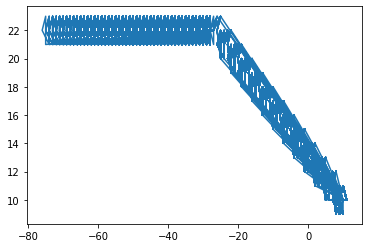

In [23]:
irissetosa_x =  x4
irissetosa_y = y4 
plt.plot(irissetosa_x, irissetosa_y)

In [31]:
input = random.choice(data)[1]
learn_rate = init_lr * alpha * (1 - 3.8/len(nodes))

recalc_nodes = []
for _ in range(50):
    # best matching unit
    l0 = [i[0] for i in input]
    l1 = [i[1] for i in input]
    l2 = [i[2] for i in input]
    l3 = [i[3] for i in input]
    #print(l0)
    l0 = l3[50:100]
    BMU = _find_bmu(l0)
    BMU.last_it = it

    neighbours = []
    neighbours.append(BMU)
    if BMU.left:  neighbours.append(BMU.left)
    if BMU.right: neighbours.append(BMU.right)
    if BMU.up:    neighbours.append(BMU.up)
    if BMU.down:  neighbours.append(BMU.down)

    if BMU not in recalc_nodes: recalc_nodes.append(BMU)
    for node in neighbours:
        node.adjust_weights(l0, learn_rate)
        if node not in recalc_nodes: recalc_nodes.append(node)
    err = _distance(BMU.weights, l0)
    growing, nodes = _node_add_error(BMU, err)
    if growing: recalc_nodes.extend(nodes)
    it += 1
    used_data = []
    for node in nodes:
        used_data.append(node.data)
    for node in recalc_nodes:
        dist = float("inf")
        winner = False
        winner_fn = False
        for fn,point in data:
            if fn in used_data: continue

            point0 = [i[3] for i in point]
            d = _distance(point0[50:100], node.weights)
            if(d < dist):
                dist = d
                winner = point0
                winner_fn = fn

        if node.data != winner_fn:
            node.data = winner_fn
            node.last_changed = it
        output.write(str(node.data) + "," + str(node.x) + "," + str(node.y)\
                + ",change\n")
        used_data.append(winner_fn)
    _remove_unused_nodes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  del sys.path[0]


Growing left at: (-178,22) -> (-179, 22)
Growing up at: (-178,22) -> (-178, 23)
Growing down at: (-178,22) -> (-178, 21)
Growing left at: (-179,22) -> (-180, 22)
Growing up at: (-179,22) -> (-179, 23)
Growing down at: (-179,22) -> (-179, 21)
Growing left at: (-180,22) -> (-181, 22)
Growing up at: (-180,22) -> (-180, 23)
Growing down at: (-180,22) -> (-180, 21)
Growing left at: (-181,22) -> (-182, 22)
Growing up at: (-181,22) -> (-181, 23)
Growing down at: (-181,22) -> (-181, 21)
Growing left at: (-182,22) -> (-183, 22)
Growing up at: (-182,22) -> (-182, 23)
Growing down at: (-182,22) -> (-182, 21)
Growing left at: (-183,22) -> (-184, 22)
Growing up at: (-183,22) -> (-183, 23)
Growing down at: (-183,22) -> (-183, 21)
Growing left at: (-184,22) -> (-185, 22)
Growing up at: (-184,22) -> (-184, 23)
Growing down at: (-184,22) -> (-184, 21)
Growing left at: (-185,22) -> (-186, 22)
Growing up at: (-185,22) -> (-185, 23)
Growing down at: (-185,22) -> (-185, 21)
Growing left at: (-186,22) -> (-

In [25]:
import pandas as pd
df = pd.read_csv('gsom.csv')
print(df.shape)
df.columns

(11046, 4)


Index(['data', '10', '10.1', 'change'], dtype='object')

In [27]:
x3 = df['10']
y3 = df['10']

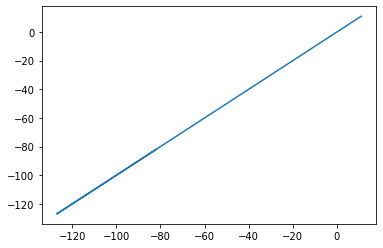

In [29]:
irisverticosa_x = x3
irisverticosa_y = y3
plt.plot(irisverticosa_x, irisverticosa_y)

In [32]:
input = random.choice(data)[1]
learn_rate = init_lr * alpha * (1 - 3.8/len(nodes))

recalc_nodes = []
for _ in range(50):
 
    l0 = [i[0] for i in input]
    l1 = [i[1] for i in input]
    l2 = [i[2] for i in input]
    l3 = [i[3] for i in input]
    #print(l0)
    l0 = l3[100:150]
    BMU = _find_bmu(l0)
    BMU.last_it = it

    neighbours = []
    neighbours.append(BMU)
    if BMU.left:  neighbours.append(BMU.left)
    if BMU.right: neighbours.append(BMU.right)
    if BMU.up:    neighbours.append(BMU.up)
    if BMU.down:  neighbours.append(BMU.down)

    if BMU not in recalc_nodes: recalc_nodes.append(BMU)
    for node in neighbours:
        node.adjust_weights(l0, learn_rate)
        if node not in recalc_nodes: recalc_nodes.append(node)

    err = _distance(BMU.weights, l0)

    growing, nodes = _node_add_error(BMU, err)
    if growing: recalc_nodes.extend(nodes)

    it += 1
    used_data = []
    for node in nodes:
        used_data.append(node.data)
    for node in recalc_nodes:
        dist = float("inf")
        winner = False
        winner_fn = False
        for fn,point in data:
            if fn in used_data: continue

            point0 = [i[3] for i in point]
            d = _distance(point0[100:150], node.weights)
            if(d < dist):
                dist = d
                winner = point0
                winner_fn = fn

        if node.data != winner_fn:
            node.data = winner_fn
            node.last_changed = it
        output.write(str(node.data) + "," + str(node.x) + "," + str(node.y)\
                + ",change\n")
        used_data.append(winner_fn)
    _remove_unused_nodes()
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  del sys.path[0]


Growing left at: (-228,22) -> (-229, 22)
Growing up at: (-228,22) -> (-228, 23)
Growing down at: (-228,22) -> (-228, 21)
Growing left at: (-229,22) -> (-230, 22)
Growing up at: (-229,22) -> (-229, 23)
Growing down at: (-229,22) -> (-229, 21)
Growing left at: (-230,22) -> (-231, 22)
Growing up at: (-230,22) -> (-230, 23)
Growing down at: (-230,22) -> (-230, 21)
Growing left at: (-231,22) -> (-232, 22)
Growing up at: (-231,22) -> (-231, 23)
Growing down at: (-231,22) -> (-231, 21)
Growing left at: (-232,22) -> (-233, 22)
Growing up at: (-232,22) -> (-232, 23)
Growing down at: (-232,22) -> (-232, 21)
Growing left at: (-233,22) -> (-234, 22)
Growing up at: (-233,22) -> (-233, 23)
Growing down at: (-233,22) -> (-233, 21)
Growing left at: (-234,22) -> (-235, 22)
Growing up at: (-234,22) -> (-234, 23)
Growing down at: (-234,22) -> (-234, 21)
Growing left at: (-235,22) -> (-236, 22)
Growing up at: (-235,22) -> (-235, 23)
Growing down at: (-235,22) -> (-235, 21)
Growing left at: (-236,22) -> (-

In [33]:
import pandas as pd
df = pd.read_csv('gsom.csv')
print(df.shape)
df.columns

(22597, 4)


Index(['data', '10', '10.1', 'change'], dtype='object')

In [43]:
x3 = df['10']
y3 = df['10.1']

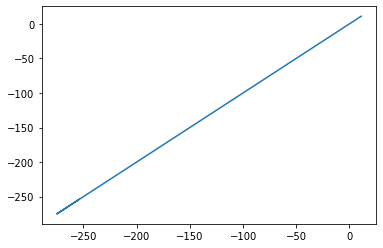

In [38]:
irisvirginica_x = x3
irisvirginica_y = y3
plt.plot(irisvirginica_x,irisvirginica_y)

In [44]:
%matplotlib inline

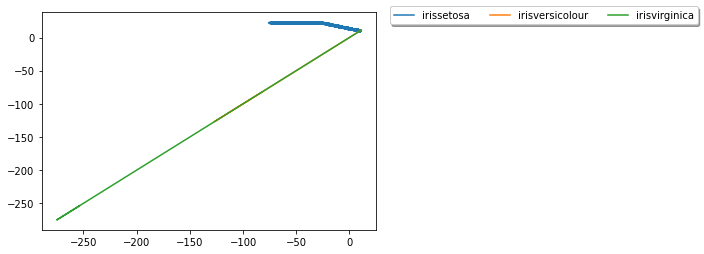

In [45]:
plt.plot(irissetosa_x, irissetosa_y, label='irissetosa')
plt.plot(irisverticosa_x, irisverticosa_y, label='irisversicolour')
plt.plot(irisvirginica_x, irisvirginica_y, label='irisvirginica')
#plt.plot(x4,y4, label='petal width')


plt.legend(('irissetosa', 'irisversicolour', 'irisvirginica'))#, 'petal width'))
plt.legend(loc='upper center', bbox_to_anchor=(1.50, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
TypeError: 'Line2D' object is not callable
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
  

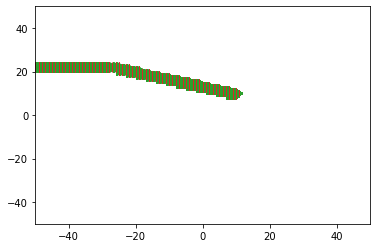

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


fig = plt.figure()
plt.ylim(-50, 50)
plt.xlim(-50, 50)
graph1, = plt.plot([], [], 'o')
graph2, = plt.plot([], [], '-')
graph3, = plt.plot([], [], '>')
graph4, = plt.plot([], [], '|')



def animate3(i):
    graph3.set_data(x3[:i+1], y3[:i+1])
    return graph3

def animate4(i):
    graph4.set_data(x4[:i+1], y4[:i+1])
    return graph4

ani3 = FuncAnimation(fig, animate3(200000))
ani4 = FuncAnimation(fig, animate4(200000))

plt.show()

In [48]:
df.head(10) # first 10 records

,data,10,10.1,change
0,target,11,10,change
1,frame,10,11,change
2,target_names,9,10,change
3,DESCR,10,9,change
4,data,10,10,change
5,target,11,10,change
6,frame,10,11,change
7,target_names,9,10,change
8,DESCR,10,9,change
9,feature_names,8,10,change


In [49]:
df.head(-20)

,data,10,10.1,change
0,target,11,10,change
1,frame,10,11,change
2,target_names,9,10,change
3,DESCR,10,9,change
4,data,10,10,change
...,...,...,...,...
22572,False,-246,21,change
22573,False,-248,22,change
22574,False,-247,23,change
22575,False,-247,21,change


In [50]:
i = 0
for _ in range(20):
    l0 = [i[0] for i in input]
    print(l0)
    BMU = _find_bmu(l0)

[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9, 5.4, 4.8, 4.8, 4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5.0, 5.0, 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5.0, 5.5, 4.9, 4.4, 5.1, 5.0, 4.5, 4.4, 5.0, 5.1, 4.8, 5.1, 4.6, 5.3, 5.0, 7.0, 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5.0, 5.9, 6.0, 6.1, 5.6, 6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7, 6.0, 5.7, 5.5, 5.5, 5.8, 6.0, 5.4, 6.0, 6.7, 6.3, 5.6, 5.5, 5.5, 6.1, 5.8, 5.0, 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3, 6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5, 7.7, 7.7, 6.0, 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2, 7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6.0, 6.9, 6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9]
[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9, 5.4, 4.8, 4.8, 4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5.0, 5.0, 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5.0, 5.5, 4.9, 4.4, 5.1, 5.0, 4.5, 4.4, 5.0, 5.1, 4.8, 5.1, 4.6, 5.3, 5.0

In [51]:
    l0 = [i[0] for i in input]
    print(l0)
    BMU = _find_bmu(l0)
    print(BMU)

[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9, 5.4, 4.8, 4.8, 4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5.0, 5.0, 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5.0, 5.5, 4.9, 4.4, 5.1, 5.0, 4.5, 4.4, 5.0, 5.1, 4.8, 5.1, 4.6, 5.3, 5.0, 7.0, 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5.0, 5.9, 6.0, 6.1, 5.6, 6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7, 6.0, 5.7, 5.5, 5.5, 5.8, 6.0, 5.4, 6.0, 6.7, 6.3, 5.6, 5.5, 5.5, 6.1, 5.8, 5.0, 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3, 6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5, 7.7, 7.7, 6.0, 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2, 7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6.0, 6.9, 6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9]


In [52]:
for fn,point in data:
    if fn in used_data: continue
    print(node.weights)

In [53]:
# sepal length sepal width petal length petal width
# Iris-Setosa - Iris-Versicolour - Iris-Virginica

In [54]:
dataset

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========